In [1]:
import numpy as np
import scipy.io as sio
from matplotlib import pyplot as plt
import xarray as xr
from xhistogram.xarray import histogram as hist
from thermodynamics import calc_sigmantr
from ariane_distributionfunctions import ariane_D1, ariane_D2, ariane_D3
from ariane_general import ariane_year

In [2]:
rootdir = '/home/ocean_personal_data/graemem/ariane/'
model = 'orca025_global_5d'
experiment = 'quant_back_seedNAn1_t*_sign27.7-28_MLrefz8delsig0.01'
filepath = rootdir+'experiments/'+model+'/'+experiment+'/ariane_positions_quantitative.nc'
filepath_initial = rootdir+'experiments/'+model+'/'+experiment+'/ariane_initial.nc'
filepath_time = rootdir+'time/time_orca025_global_5d.mat'
# Universal variables
spy = 365*24*60*60
yrst = 1958
yrend = 2016
ventsec = 7
lastinit = 4217
Cp = 4200

In [3]:
# Ariane input
ds_initial = xr.open_mfdataset(filepath_initial,combine='nested',concat_dim='ntraj')
ds_initial.init_volume.name = 'init_volume'
# Ariane output
ds = xr.open_mfdataset(filepath,combine='nested',concat_dim='ntraj')
ds = xr.merge([ds, ds_initial.init_volume])
ds['final_age'] = ds.final_age.astype('timedelta64[s]').astype('float64')/spy
ds['final_dens'] = calc_sigmantr(ds.final_temp,ds.final_salt)
# Model times
time_vals = np.append(np.array([0]),sio.loadmat(filepath_time)['time'].squeeze())
time = xr.DataArray(time_vals,dims=['nfile'],coords={'nfile':np.arange(time_vals.size)})

In [4]:
# Bins
years = np.arange(yrst,yrend+1)
ages = np.arange(-3/12,yrend-yrst+9/12)
densities = np.arange(27.7,28,0.01)
init_t_unique = np.unique(ds.init_t)
inits = np.append(init_t_unique-0.5,init_t_unique[-1]+0.5)

In [30]:
final_year = ariane_year(ds.final_t,time,dim='nfile',yrst = yrst, secondsperyear = spy)
ds = xr.merge([ds,final_year.drop('nfile')])

## Age

In [6]:
# Volumetric distribution of age, for last initialisation
S = (ds.final_section==ventsec) & (ds.init_t==lastinit)
V_fage = ariane_D1(
    var1=ds.final_age,
    bins=[ages],
    dim=['ntraj'],
    weights=ds.init_volume,
    subset=True,
    conditional=S
        )

In [7]:
# Volumetric distribution of age, averaged across initialisations
S = (ds.final_section==ventsec)
V_fage_it = ariane_D2(
    var1=ds.final_age, var2=ds.init_t,
    bins=[ages,inits],
    dim=['ntraj'],
    weights=ds.init_volume,
    subset=True,
    conditional=S
        )
# Keep only nonzero values (if zero we can assume that age exceeds max runtime of trajectory calculation)
# Take mean over initialisation times, ignoring nans
V_fage_itmean = Dage_mean.where(Dage_mean!=0).mean(dim='init_t_bin')

In [8]:
# Calculate the anomaly and load the data
V_year_anom = ((V_age-V_age_itmean)/V_age_itmean).rename(
    {'final_age_bin':'final_year_bin'}).assign_coords(
    final_year_bin=np.flip(years[:-1]+years[1:])/2)
V_year_anom.load();

<BarContainer object of 58 artists>

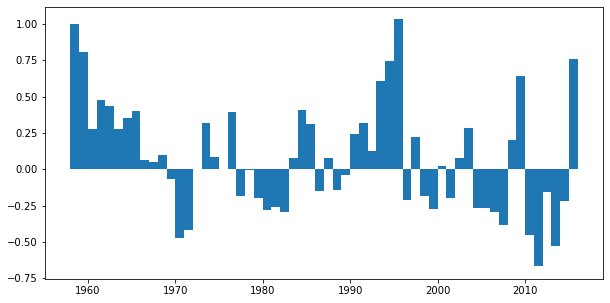

In [9]:
fig,ax = plt.subplots(figsize=(10,5),nrows=1)
ax.bar(V_year_anom.final_year_bin,V_year_anom,width=1)

## Age-density

In [6]:
# Volumetric joint distribution of age-density-initialization
S = (ds.final_section==ventsec)
V_fage_idens_it = ariane_D3(ds.final_age,ds.init_dens,ds.init_t,
               bins=[ages,densities,inits],
               dim=['ntraj'],
               weights=ds.init_volume,
               subset=True,
               conditional=S)

end


In [22]:
# Average over initialisation time
V_fage_idens_itmean = V_fage_idens_it.where(V_fage_idens_it!=0).mean(dim='init_t_bin')

In [23]:
# Volumetric joint distribution of age-density, for last intialisation
S = (ds.final_section==ventsec) & (ds.init_t == lastinit)
V_fage_idens = ariane_D2(var1=ds.final_age, var2 = ds.init_dens,
                    bins=[ages,densities],
                    dim=['ntraj'],
                    weights=ds.init_volume,
                    subset=True,
                    conditional=S)

In [27]:
V_fyear_idens_anom = ((V_fage_idens-V_fage_idens_itmean)/V_fage_idens_itmean).rename(
    {'final_age_bin':'final_year_bin'}).assign_coords(
    final_year_bin=np.flip(years[:-1]+years[1:])/2)
V_fyear_idens_anom.load();

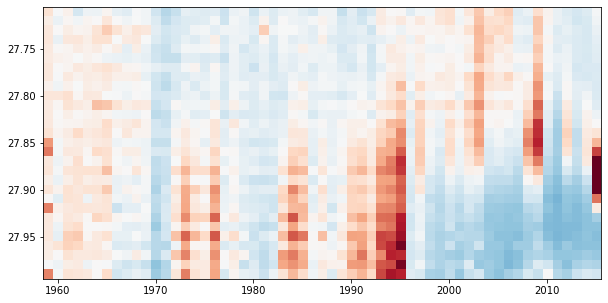

In [34]:
fig,ax = plt.subplots(figsize=(10,5),nrows=1)
ax.pcolormesh(V_fyear_idens_anom.final_year_bin,V_fyear_idens_anom.init_dens_bin,V_fyear_idens_anom.transpose(),vmin=-2,vmax=2,cmap='RdBu_r')
ax.invert_yaxis()

## Age (volume-weighted mean temperature)

In [68]:
# Volume-weighted mean temperature (at subduction) as a function age, for all initialisation
S = (ds.final_section==ventsec)
iV_fage_it = ariane_D2(
    var1=ds.final_age, var2=ds.init_t,
    bins=[ages,inits],
    dim=['ntraj'],
    weights=ds.init_volume,
    subset=True,
    conditional=S
        )
iTiV_fage_it = ariane_D2(
    var1=ds.final_age, var2=ds.init_t,
    bins=[ages,inits],
    dim=['ntraj'],
    weights=ds.init_temp*ds.init_volume,
    subset=True,
    conditional=S
        )
iT_fage_it = iTiV_fage_it/iV_fage_it
iT_fage_itmean = iT_fage_it.where(iT_fage_it!=0).mean(dim='init_t_bin')

In [69]:
# Volume-weighted mean temperature (at subduction) as a function age, for last initialisation
S = (ds.final_section==ventsec) & (ds.init_t==lastinit)
iV_fage = ariane_D1(
    var1=ds.final_age,
    bins=[ages],
    dim=['ntraj'],
    weights=ds.init_volume,
    subset=True,
    conditional=S
        )
iTiV_fage = ariane_D1(
    var1=ds.final_age,
    bins=[ages],
    dim=['ntraj'],
    weights=ds.init_temp*ds.init_volume,
    subset=True,
    conditional=S
        )
iT_fage = iTiV_fage/iV_fage

In [70]:
iT_fyear_anom = ((iT_fage-iT_fage_itmean)/iT_fage_itmean).rename(
    {'final_age_bin':'final_year_bin'}).assign_coords(
    final_year_bin=np.flip(years[:-1]+years[1:])/2)
iT_fyear_anom.load();

/home/users/graemem/miniconda/envs/ariane/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


<BarContainer object of 58 artists>

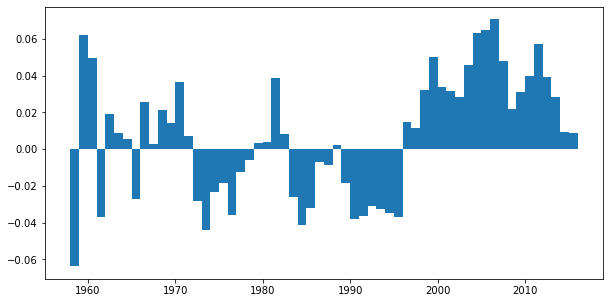

In [73]:
fig,ax = plt.subplots(figsize=(10,5),nrows=1)
ax.bar(iT_fyear_anom.final_year_bin,iT_fyear_anom,width=1)

## Age-density (volume-weighted mean temperature)

In [47]:
# Volume-weigthed mean temperature in subsurface as function of age-density-initialization
S = (ds.final_section==ventsec) & (ds.init_lat<65)
iV_fage_idens_it = ariane_D3(ds.final_age,ds.init_dens,ds.init_t,
               bins=[ages,densities,inits],
               dim=['ntraj'],
               weights=ds.init_volume,
               subset=True,
               conditional=S,
               verbose=False)
iTiV_fage_idens_it = ariane_D3(ds.final_age,ds.init_dens,ds.init_t,
               bins=[ages,densities,inits],
               dim=['ntraj'],
               weights=ds.init_volume*ds.init_temp,
               subset=True,
               conditional=S,
               verbose=False)
iT_fage_idens_it = iTiV_fage_idens_it/iV_fage_idens_it
iT_fage_idens_it.name = 'T'
iT_fage_idens_it.to_dataset().to_netcdf('data/processed/lagrangian/iT_fage_idens_it.nc',mode='w')

end
end


PermissionError: [Errno 13] Permission denied: b'/home/ocean_personal_data/graemem/ariane/python/draw_figs_nadw_var/data/processed/lagrangian/iT_fage_idens_it.nc'

In [41]:
# Volume-weighted mean temperature st subduction as function of age-density-initialization
S = (ds.final_section==ventsec)
iV_fage_idens_it = ariane_D3(ds.final_age,ds.init_dens,ds.init_t,
               bins=[ages,densities,inits],
               dim=['ntraj'],
               weights=ds.init_volume,
               subset=True,
               conditional=S,
               verbose=False)
fTiV_fage_idens_it = ariane_D3(ds.final_age,ds.init_dens,ds.init_t,
               bins=[ages,densities,inits],
               dim=['ntraj'],
               weights=ds.init_volume*ds.final_temp,
               subset=True,
               conditional=S,
               verbose=False)
fT_fage_idens_it = fTiV_fage_idens_it/iV_fage_idens_it
fT_fage_idens_it.name = 'T'
fT_fage_idens_it.to_dataset().to_netcdf('data/processed/lagrangian/fT_fage_idens_it.nc',mode='w')

end
end


PermissionError: [Errno 13] Permission denied: b'/home/ocean_personal_data/graemem/ariane/python/draw_figs_nadw_var/data/processed/lagrangian/fT_fage_idens_it.nc'

In [ ]:
# Average over initialisation time
iT_fage_idens_itmean = iT_fage_idens_it.where(V_fage_idens_it!=0).mean(dim='init_t_bin')

In [ ]:
# Volumetric joint distribution of age-density, for last intialisation
S = (ds.final_section==ventsec) & (ds.init_t == lastinit)
iV_fage_idens = ariane_D2(var1=ds.final_age, var2 = ds.init_dens,
                    bins=[ages,densities],
                    dim=['ntraj'],
                    weights=ds.init_volume,
                    subset=True,
                    conditional=S,
                    subsetname='final_section-7_init_t-last'
                    save=True)
weights = ds.init_volume*ds.init_temp
weights.name = 'iViT'
iTiV_fage_idens = ariane_D2(var1=ds.final_age, var2 = ds.init_dens,
                    bins=[ages,densities],
                    dim=['ntraj'],
                    weights=weight,
                    subset=True,
                    conditional=S,
                    subsetname='final_section-7_init_t-last'
                    save=True)
iT_fage_idens = iTiV_fage_idens/iV_fage_idens

In [ ]:
iT_fage_idens.to_dataset.to_netcdf('data/processed/lagrangian/iT_fage_idens.nc',mode='w')

In [ ]:
iT_fyear_idens_anom = (iT_fage_idens-iT_fage_idens_itmean).rename(
    {'final_age_bin':'final_year_bin'}).assign_coords(
    final_year_bin=np.flip(years[:-1]+years[1:])/2)
iT_fyear_idens_anom.load();

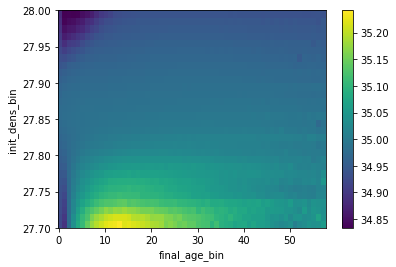

In [65]:
iT_fage_idens_itmean.transpose().plot()

In [5]:
S = (ds.final_section==ventsec) & (ds.init_lat<65)
iV_fage_idens_it = ariane_D3(ds.final_age,ds.init_dens,ds.init_t,
               bins=[ages,densities,inits],
               dim=['ntraj'],
               weights=ds.init_volume,
               subset=True,
               conditional=S,
               subsetname='final_section-7_init_lat-l65',
               verbose=True,
               save=True)

init_t : 1367.5 to 1440.5
init_t : 1440.5 to 1513.5
init_t : 1513.5 to 1586.5
init_t : 1586.5 to 1659.5
init_t : 1659.5 to 1732.5
init_t : 1732.5 to 1805.5
init_t : 1805.5 to 1878.5
init_t : 1878.5 to 1952.5
init_t : 1952.5 to 2025.5
init_t : 2025.5 to 2098.5
init_t : 2098.5 to 2171.5
init_t : 2171.5 to 2244.5
init_t : 2244.5 to 2317.5
init_t : 2317.5 to 2390.5
init_t : 2390.5 to 2463.5
init_t : 2463.5 to 2536.5
init_t : 2536.5 to 2609.5
init_t : 2609.5 to 2682.5
init_t : 2682.5 to 2755.5
init_t : 2755.5 to 2828.5
init_t : 2828.5 to 2901.5
init_t : 2901.5 to 2974.5
init_t : 2974.5 to 3047.5
init_t : 3047.5 to 3120.5
init_t : 3120.5 to 3193.5
init_t : 3193.5 to 3266.5
init_t : 3266.5 to 3339.5
init_t : 3339.5 to 3413.5
init_t : 3413.5 to 3486.5
init_t : 3486.5 to 3559.5
init_t : 3559.5 to 3632.5
init_t : 3632.5 to 3705.5
init_t : 3705.5 to 3778.5
init_t : 3778.5 to 3851.5
init_t : 3851.5 to 3924.5
init_t : 3924.5 to 3997.5
init_t : 3997.5 to 4070.5
init_t : 4070.5 to 4143.5
init_t : 414

In [6]:
weights = ds.init_volume*ds.init_temp
weights.name = 'iViT'
iTiV_fage_idens_it = ariane_D3(ds.final_age,ds.init_dens,ds.init_t,
               bins=[ages,densities,inits],
               dim=['ntraj'],
               weights=ds.init_volume*ds.init_temp,
               subset=True,
               conditional=S,
               subsetname='final_section-7_init_lat-l65',
               verbose=True,
               save=True)

init_t : 1367.5 to 1440.5
init_t : 1440.5 to 1513.5
init_t : 1513.5 to 1586.5
init_t : 1586.5 to 1659.5
init_t : 1659.5 to 1732.5
init_t : 1732.5 to 1805.5
init_t : 1805.5 to 1878.5
init_t : 1878.5 to 1952.5
init_t : 1952.5 to 2025.5
init_t : 2025.5 to 2098.5
init_t : 2098.5 to 2171.5
init_t : 2171.5 to 2244.5
init_t : 2244.5 to 2317.5
init_t : 2317.5 to 2390.5
init_t : 2390.5 to 2463.5
init_t : 2463.5 to 2536.5
init_t : 2536.5 to 2609.5
init_t : 2609.5 to 2682.5
init_t : 2682.5 to 2755.5
init_t : 2755.5 to 2828.5
init_t : 2828.5 to 2901.5
init_t : 2901.5 to 2974.5
init_t : 2974.5 to 3047.5
init_t : 3047.5 to 3120.5
init_t : 3120.5 to 3193.5
init_t : 3193.5 to 3266.5
init_t : 3266.5 to 3339.5
init_t : 3339.5 to 3413.5
init_t : 3413.5 to 3486.5
init_t : 3486.5 to 3559.5
init_t : 3559.5 to 3632.5
init_t : 3632.5 to 3705.5
init_t : 3705.5 to 3778.5
init_t : 3778.5 to 3851.5
init_t : 3851.5 to 3924.5
init_t : 3924.5 to 3997.5
init_t : 3997.5 to 4070.5
init_t : 4070.5 to 4143.5
init_t : 414

NameError: name 'error' is not defined